**Entrega LSTM**. Joaquim Novillo - MEBDS 20-21   
El objetivo de esta práctica es predecir el precio de la energía para las próximas 24h.

## Carga ficheros

In [ ]:
import tensorflow as tf
from tensorflow import keras
import datetime
%load_ext tensorboard

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
import seaborn as sns
import time

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Docs capítulo 4 (Machine Learning)/Tensorflow y Keras (Albert)/Entrega/energy_price.csv', sep=',')

In [ ]:
df

,date,(UTC),Price
0,01/01/2015,0:00,48.10
1,01/01/2015,1:00,47.33
2,01/01/2015,2:00,42.27
3,01/01/2015,3:00,38.41
4,01/01/2015,4:00,35.72
...,...,...,...
11585,27/04/2016,17:00,34.61
11586,27/04/2016,18:00,35.53
11587,27/04/2016,19:00,40.69
11588,27/04/2016,20:00,38.29


In [ ]:
df["Date"] = df["date"] +' '+df["(UTC)"]
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y %H:%M')
df.drop(['date', '(UTC)'], axis=1, inplace=True)
df = df[['Date', 'Price']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11590 entries, 0 to 11589
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11590 non-null  datetime64[ns]
 1   Price   11590 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 181.2 KB


In [ ]:
price = df['Price']
price.index = df['Date']
price.head()

Date
2015-01-01 00:00:00    48.10
2015-01-01 01:00:00    47.33
2015-01-01 02:00:00    42.27
2015-01-01 03:00:00    38.41
2015-01-01 04:00:00    35.72
Name: Price, dtype: float64

## EDA

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faeac95c7d0>],
      dtype=object)

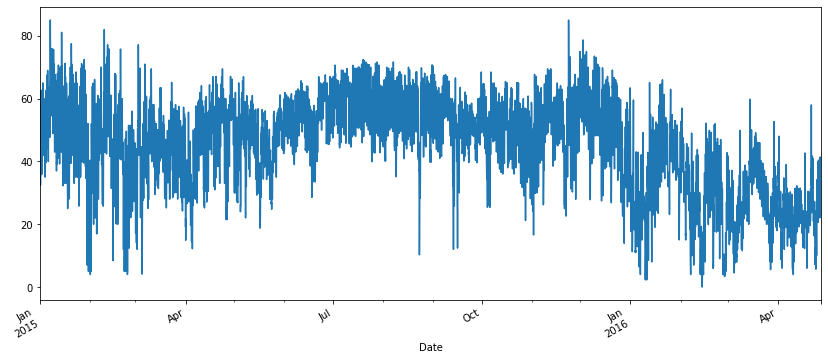

In [ ]:
price.plot(subplots=True,figsize=[14,6])

In [ ]:
price.describe()

count    11590.000000
mean        45.142519
std         15.431769
min          0.000000
25%         35.000000
50%         47.155000
75%         57.250000
max         85.050000
Name: Price, dtype: float64

In [ ]:
price.head(), price.tail()

(Date
 2015-01-01 00:00:00    48.10
 2015-01-01 01:00:00    47.33
 2015-01-01 02:00:00    42.27
 2015-01-01 03:00:00    38.41
 2015-01-01 04:00:00    35.72
 Name: Price, dtype: float64, Date
 2016-04-27 17:00:00    34.61
 2016-04-27 18:00:00    35.53
 2016-04-27 19:00:00    40.69
 2016-04-27 20:00:00    38.29
 2016-04-27 21:00:00    33.61
 Name: Price, dtype: float64)

In [ ]:
price.isnull().values.any()

False

Nos encontramos con un *lifespan* de un año y casi 5 meses: desde 1 de enero 2015 hasta el 27 de abril de 2016. \
El mínimo de precio ha sido de 0 unidades monetarias y el máximo de 85,05. \
La media de precio ha sido de 45,14

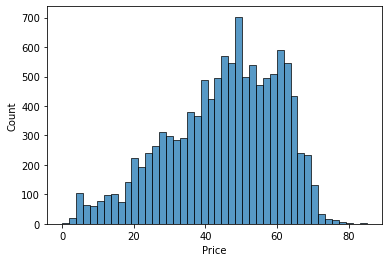

In [ ]:
sns.histplot(price)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


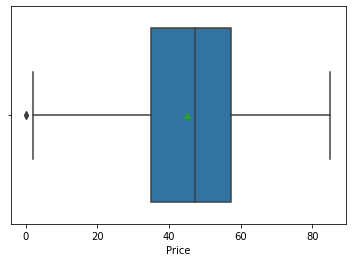

In [ ]:
sns.boxplot(price, showmeans=True)

Por distribución observamos que los valores están algo desplazados a la izquierda. La media es ligeramente inferior a la media, debido a cierto peso de los valores más bajos. 

Si descomponemos la serie observamos que:  

*   la tendencia (*trend*) era en línea general estacionaria (con cierta fluctuación) hasta finales de 2015, cuando se aprecia una tendencia bajista de precio a principios de 2016. 
*   Parece que no hay estacionalidad en los datos. Los datos varían de la misma forma durante las mismas épocas del año. 
* Durante la serie nos encontramos con ciertos puntos donde parece que los residuos se escapan. Es debido a patrones que no se pueden predecir, debido a shocks en la oferta o demanda, afectando al precio. Coinciden con los momentos de bajadas pronunciadas de precio.
Será importante tenerlo en cuenta porque éstos no se corresponden con patrones predecibles.




/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


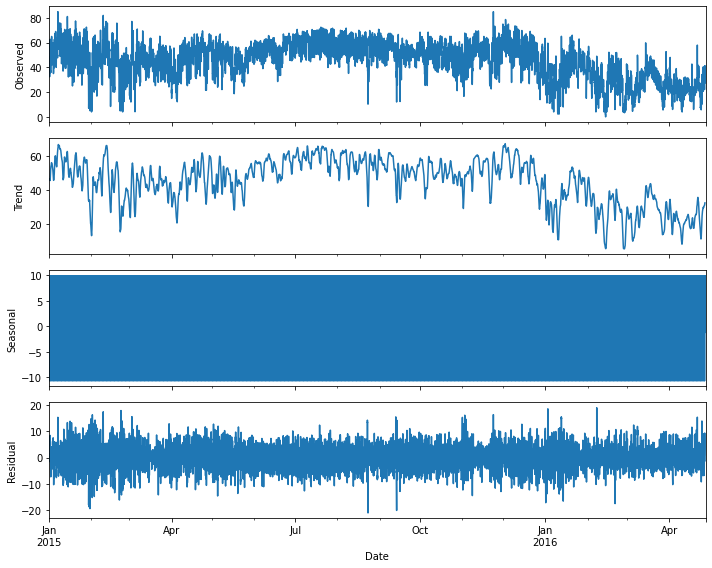

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(price)
plt.rcParams['figure.figsize'] = (10, 8)
x = result.plot()

## Modelado

Usaremos un modelo basado en redes neuronales recurrentes (RNN) y en concreto un tipo de ellas llamadas LSTM (*Long short-term memory*) para definir el baseline. Las LSTM tienen la ventaja de tener conectores "de memoria", es decir, es capaz de recordar valores de capas anteriores, siendo posible entrenar modelos como series de tiempo o interpretación de textos, es decir, modelos donde acciones pasadas tengan consecuencias en las acciones actuales. 

In [ ]:
TRAIN_SPLIT = 9000

In [ ]:
tf.random.set_seed(14)

In [ ]:
price = price.values

Estandarizamos las variables. Debemos acordarnos que en la salida del modelo debemos devolverlas a su estado no normalizado.

In [ ]:
price_train_mean = price[:TRAIN_SPLIT].mean()
price_train_std = price[:TRAIN_SPLIT].std()

price = (price-price_train_mean)/price_train_std

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size])
  return np.array(data), np.array(labels)

Hemos de predecir 12 horas en adelante. Cogemos las 24h anteriores para crear el modelo baseline.

In [ ]:
past_history = 24
future_target = 12

x_train, y_train = univariate_data(price, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val, y_val = univariate_data(price, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  
  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

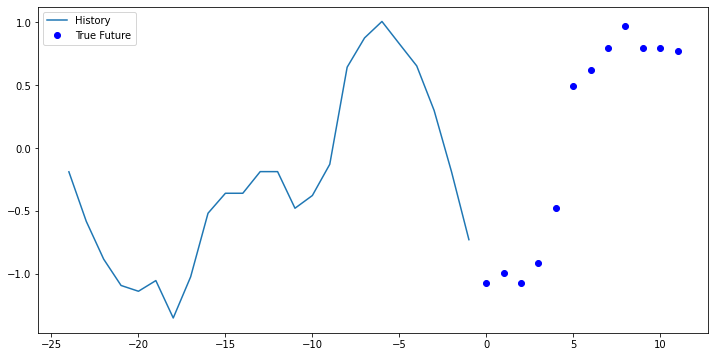

In [ ]:
multi_step_plot(x_train[1], y_train[1], np.zeros_like(y_train[1]))

Nuestro modelo tiene que ser capaz de predecir los puntos en azul, que son los valores reales de la serie. 

### Modelo Baseline

Usaremos las LSTM, *Long Short-term memory*, que son un tipo de redes neuronales recurrentes (RNN). A diferencia de otras redes neuronales, éstas tienen conexiones entre las neuronas, por lo que pueden procesar secuencias de datos (textos, audio, voz y, como en este caso, series temporales). En cierto modo son capaces de almacenar (a nuestro gusto) la información que creamos importantes y cual descartar. 

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation = validation.batch(BATCH_SIZE)

Nuestro baseline será el modelo secuencial con un 8 neuronas y una capa de entrada de (24,1). La formaran sólo una capa oculta y la salida será una Dense.   
Lo que se conoce como Vanilla LSTM.    
  

En la literatura encuentro algunos ejemplos de qué loss function usar. La literatura se decanta indistintamente por el MeanSquaredError (MSE) y el MeanAbsoluteError (MAE). El que sí elimina, y no usaré en consecuencia, es el MeanAbsolutePercentageError (MAPE).  
 
Previamente al desarrollo del modelo tanto baseline como los mejorados se ha encontrado que los modelos basados en MSE se han comportado mejor, sin tantos picos tanto en el train como el test.

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(future_target)
])

simple_lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

In [ ]:
EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = simple_lstm_model.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 4s 18ms/step - loss: 0.9365 - accuracy: 0.0841 - val_loss: 2.5427 - val_accuracy: 0.0799
Epoch 2/20
100/100 [==============================] - 1s 12ms/step - loss: 0.7468 - accuracy: 0.0958 - val_loss: 1.6707 - val_accuracy: 0.0818
Epoch 3/20
100/100 [==============================] - 1s 12ms/step - loss: 0.6638 - accuracy: 0.1252 - val_loss: 1.1819 - val_accuracy: 0.0807
Epoch 4/20
100/100 [==============================] - 1s 12ms/step - loss: 0.6187 - accuracy: 0.1367 - val_loss: 0.9413 - val_accuracy: 0.0807
Epoch 5/20
100/100 [==============================] - 1s 12ms/step - loss: 0.5879 - accuracy: 0.1386 - val_loss: 0.7798 - val_accuracy: 0.0854
Epoch 6/20
100/100 [==============================] - 1s 12ms/step - loss: 0.5683 - accuracy: 0.1387 - val_loss: 0.7140 - val_accuracy: 0.0830
Epoch 7/20
100/100 [==============================] - 1s 12ms/step - loss: 0.5539 - accuracy: 0.1520 - val_loss: 0.6829 - val_accuracy: 0.0936

Tenemos dos opciones para visualizar los resultados: Tensorboard o una función que cogí de otro ipynb. 

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: 
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


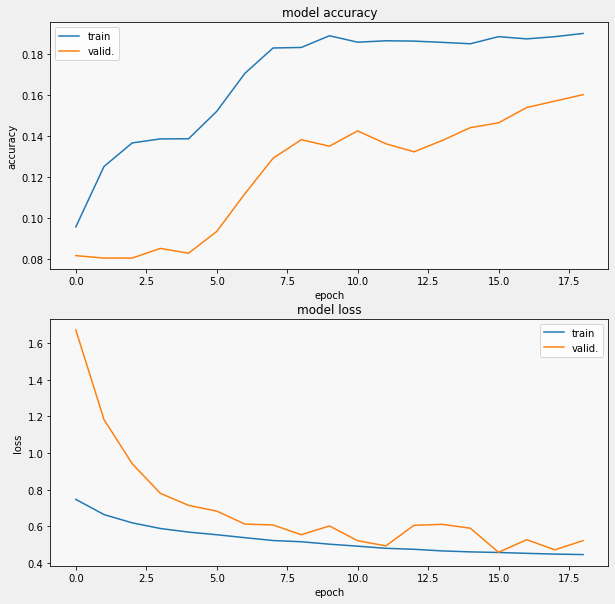

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

Gráficamente:

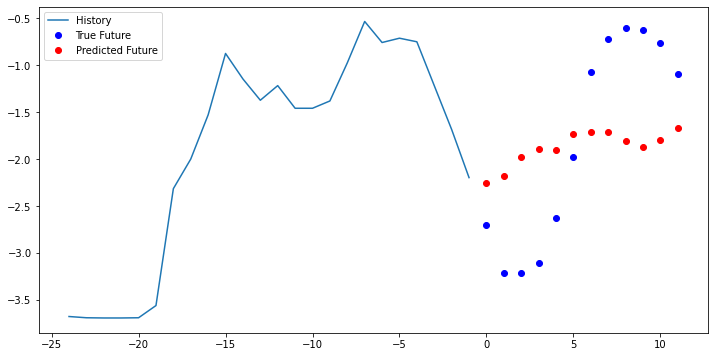

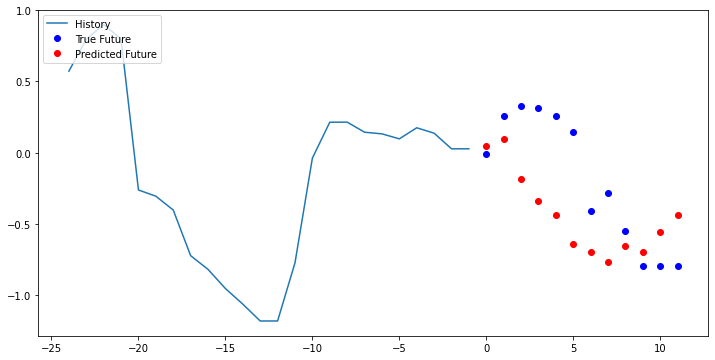

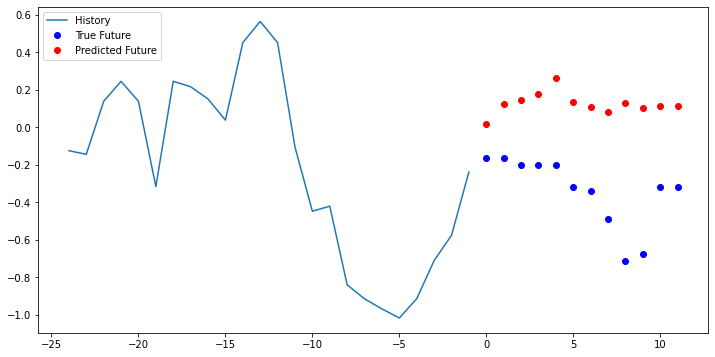

In [ ]:
for x, y in validation.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0])


In [ ]:
y_pred_simple=simple_lstm_model.predict(x_val)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=simple_lstm_model.predict(x_val))
mae = mae(y_true=y_val, y_pred=y_pred_simple)

print(ms_error, mae)

0.521710748696787 0.5736734824497316


In [ ]:
print(ms_error*price_train_std+price_train_mean)
print(mae*price_train_std+price_train_mean)

56.469917619188315
57.13781493578802


Nuestro modelo baseline a batir ha conseguido una accuracy del 15,2% sobre el conjunto de validación, es un modelo bastante pobre. Como observamos gráficamente el modelo se comporta de forma esperada, aunque no pueda predecir como queríamos: ambas *losses* convergen y la accuracy aumenta, con algun pico.
A nivel de predicción observamos que el error, tanto el cuádratico medio como el absoluto medio, des-normalizado ambos es de 55 y 56 unidades respectivamente. 

### Vanilla con capa oculta de 56 neuronas. 
y empezamos a usar una semana entera para entrenar. 

Lo primero que nos viene en mente antes de complicar el modelo es aumentar el espacio de tiempo que hemos cogido para entrenar. En este caso cogeremos 7 días (es decir, 168 horas) para poder predecir las 24h siguientes. 
El modelo será el mismo con sólo una capa oculta pero añadiremos 56 neuronas en ella. Es decir, multiplicamos por 7 el número de neuronas. 

In [ ]:
past_history = 168
future_target = 12

x_train, y_train = univariate_data(price, 0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)
x_val, y_val = univariate_data(price, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

validation = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation = validation.batch(BATCH_SIZE)

In [ ]:
lstm_56 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(56, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(future_target)
])

lstm_56.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_56.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 30s 286ms/step - loss: 0.7100 - accuracy: 0.0873 - val_loss: 0.6751 - val_accuracy: 0.0971
Epoch 2/20
100/100 [==============================] - 28s 283ms/step - loss: 0.5803 - accuracy: 0.1384 - val_loss: 0.5603 - val_accuracy: 0.1087
Epoch 3/20
100/100 [==============================] - 28s 279ms/step - loss: 0.4019 - accuracy: 0.1656 - val_loss: 0.5228 - val_accuracy: 0.2000
Epoch 4/20
100/100 [==============================] - 28s 278ms/step - loss: 0.2980 - accuracy: 0.2897 - val_loss: 0.4815 - val_accuracy: 0.2461
Epoch 5/20
100/100 [==============================] - 28s 278ms/step - loss: 0.2688 - accuracy: 0.3404 - val_loss: 0.6274 - val_accuracy: 0.2456
Epoch 6/20
100/100 [==============================] - 28s 277ms/step - loss: 0.2566 - accuracy: 0.3553 - val_loss: 0.4563 - val_accuracy: 0.2826
Epoch 7/20
100/100 [==============================] - 28s 275ms/step - loss: 0.2500 - accuracy: 0.3586 - val_loss: 0.4256 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


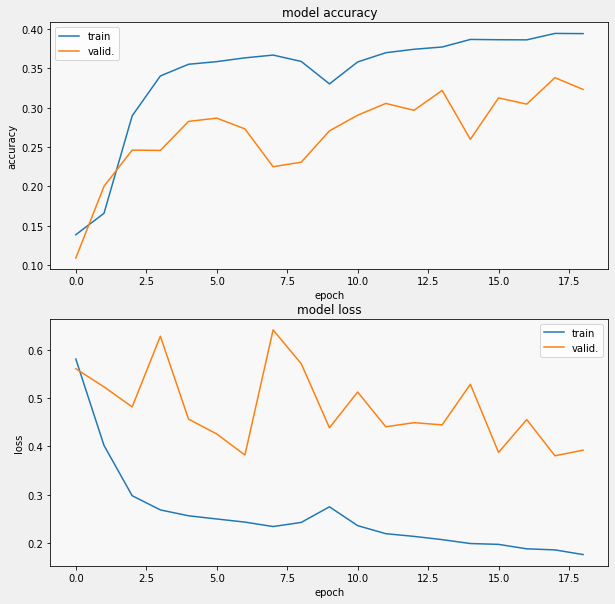

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_56.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_56.predict(x_val))

print(ms_error)

0.3921593491958242


In [ ]:
print(ms_error*price_train_std+price_train_mean)

54.80474287107325


Hemos conseguido aumentar la accuracy del modelo, siendo el 15% para las 5 últimas epochs para el modelo baseline (el cual entrenaba con 24h para predecir las siguientes 12h) a un 30%, entrenando con 7 días antes para predecir las siguientes 12h. 
Parece que hay un problema de overfitting, al encontrarnos con losses y accuracys sobre validación sin una clara tendencia bajista, sino que presenta picos.   
Independientemente, observamos que el modelo duplica la accuracy habiéndose entrenado con un período de tiempo más amplio, en este caso de 168h (7 días) anteriores. 

Gráficamente observamos como en algunos casos es capaz de acertar como mínimo la tendencia (si sube o baja el precio), pero aún no es capaz de acertar la magnitud de esos cambios. 

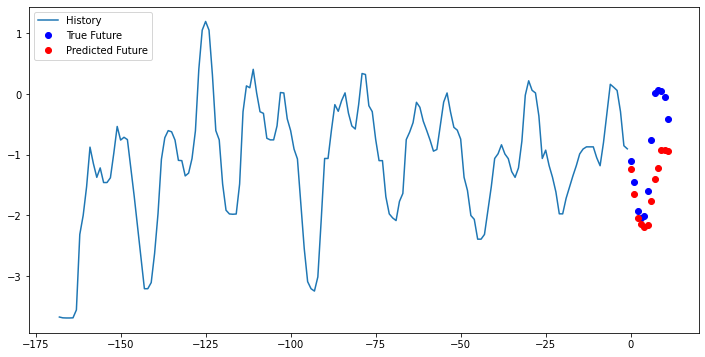

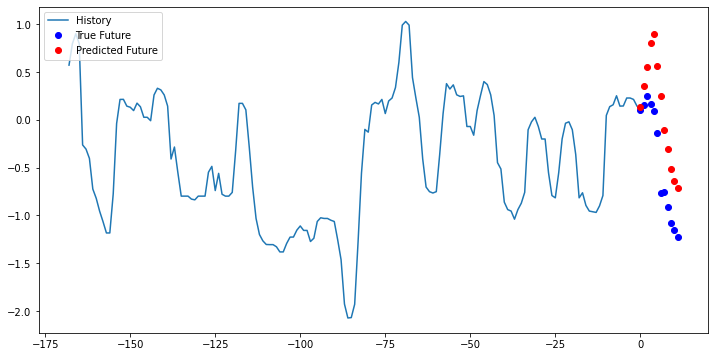

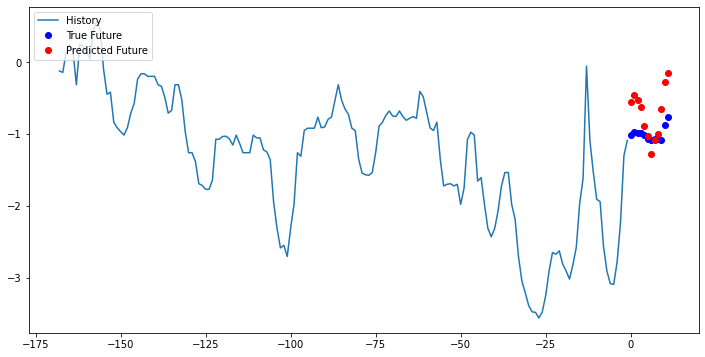

In [ ]:
for x, y in validation.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), lstm_56.predict(x)[0])

### Vanilla con capa oculta de 28 neuronas

Para intentar aplacar algo el problema del overfitting, bajamos las neuronas de la capa oculta. 

In [ ]:
lstm_28 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(28, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(future_target)
])

lstm_28.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_28.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 14s 125ms/step - loss: 0.8006 - accuracy: 0.0850 - val_loss: 0.9546 - val_accuracy: 0.1108
Epoch 2/20
100/100 [==============================] - 12s 120ms/step - loss: 0.6200 - accuracy: 0.1150 - val_loss: 0.6054 - val_accuracy: 0.1137
Epoch 3/20
100/100 [==============================] - 12s 119ms/step - loss: 0.5615 - accuracy: 0.1302 - val_loss: 0.5179 - val_accuracy: 0.1033
Epoch 4/20
100/100 [==============================] - 12s 120ms/step - loss: 0.4379 - accuracy: 0.1576 - val_loss: 0.4065 - val_accuracy: 0.1664
Epoch 5/20
100/100 [==============================] - 12s 120ms/step - loss: 0.3595 - accuracy: 0.2088 - val_loss: 0.3916 - val_accuracy: 0.1768
Epoch 6/20
100/100 [==============================] - 12s 121ms/step - loss: 0.3251 - accuracy: 0.2432 - val_loss: 0.3949 - val_accuracy: 0.1946
Epoch 7/20
100/100 [==============================] - 12s 122ms/step - loss: 0.3072 - accuracy: 0.2736 - val_loss: 0.5021 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


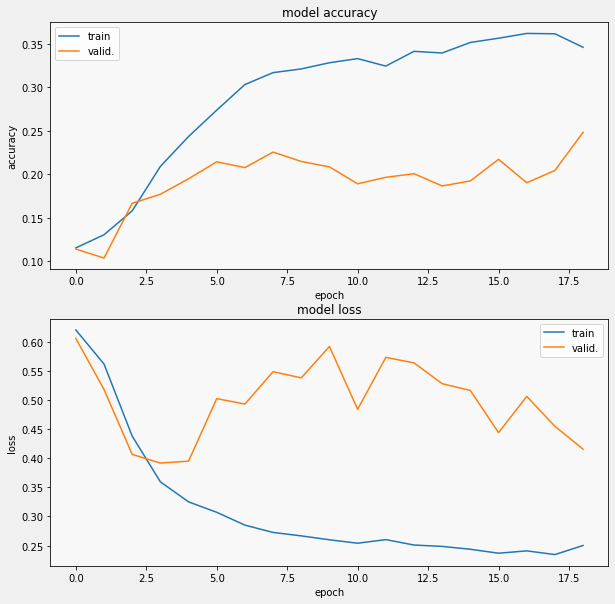

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_28.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_28.predict(x_val))

print(ms_error)

0.4154152266235258


In [ ]:
print(ms_error*price_train_std+price_train_mean)

55.10365974875299


Reducir el número de neuronas ha hecho el modelo peor y parece que no hemos corregido el overfitting. El MSE aumenta hasta los 55,1 habiendo obtenido un 54,8. SObre la accuraccy sobre validación reducimos del 30% al 21%. Eliminamos. 

### Vanilla con capa oculta de 28 y dropout. 

Veamos si aplicando un dropout del 40% mejoramos el modelo. 

In [ ]:
lstm_28_drop = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(28, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(future_target)
])

lstm_28_drop.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_28_drop.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 14s 125ms/step - loss: 0.7922 - accuracy: 0.0836 - val_loss: 1.0898 - val_accuracy: 0.0896
Epoch 2/20
100/100 [==============================] - 12s 122ms/step - loss: 0.6540 - accuracy: 0.1045 - val_loss: 0.6878 - val_accuracy: 0.1046
Epoch 3/20
100/100 [==============================] - 12s 123ms/step - loss: 0.5844 - accuracy: 0.1312 - val_loss: 0.5367 - val_accuracy: 0.1174
Epoch 4/20
100/100 [==============================] - 12s 124ms/step - loss: 0.4845 - accuracy: 0.1443 - val_loss: 0.4635 - val_accuracy: 0.1568
Epoch 5/20
100/100 [==============================] - 12s 124ms/step - loss: 0.4441 - accuracy: 0.1655 - val_loss: 0.4549 - val_accuracy: 0.1656
Epoch 6/20
100/100 [==============================] - 12s 123ms/step - loss: 0.4127 - accuracy: 0.1886 - val_loss: 0.4440 - val_accuracy: 0.1788
Epoch 7/20
100/100 [==============================] - 12s 123ms/step - loss: 0.3928 - accuracy: 0.2042 - val_loss: 0.3704 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


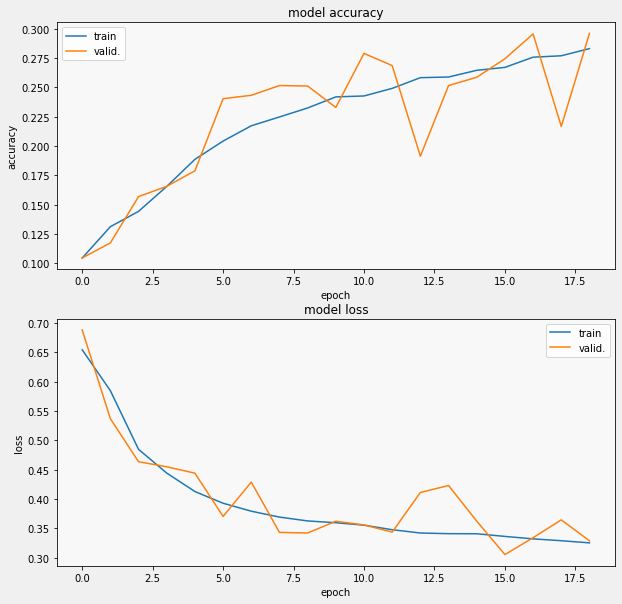

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_28_drop.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_28_drop.predict(x_val))

print(ms_error)

0.32881002041264673


In [ ]:
print(ms_error*price_train_std+price_train_mean)

53.990489200282134


A pesar de los picos importantes, le hemos añadido un dropout del 40% y el MSE ha mejorado y seguimos obteniendo una accuracy sobre validación del 26%

### Vanilla con capa oculta de 56 y dropout

In [ ]:
lstm_56_drop = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(56, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(future_target)
])

lstm_56_drop.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_56_drop.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 31s 292ms/step - loss: 0.7467 - accuracy: 0.0833 - val_loss: 0.7704 - val_accuracy: 0.0917
Epoch 2/20
100/100 [==============================] - 29s 286ms/step - loss: 0.6146 - accuracy: 0.1067 - val_loss: 0.6135 - val_accuracy: 0.1178
Epoch 3/20
100/100 [==============================] - 28s 284ms/step - loss: 0.4785 - accuracy: 0.1445 - val_loss: 0.4577 - val_accuracy: 0.1660
Epoch 4/20
100/100 [==============================] - 29s 286ms/step - loss: 0.3883 - accuracy: 0.1842 - val_loss: 0.4207 - val_accuracy: 0.2461
Epoch 5/20
100/100 [==============================] - 28s 283ms/step - loss: 0.3634 - accuracy: 0.2020 - val_loss: 0.4526 - val_accuracy: 0.2402
Epoch 6/20
100/100 [==============================] - 28s 281ms/step - loss: 0.3441 - accuracy: 0.2299 - val_loss: 0.5002 - val_accuracy: 0.2452
Epoch 7/20
100/100 [==============================] - 28s 283ms/step - loss: 0.3268 - accuracy: 0.2477 - val_loss: 0.5895 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


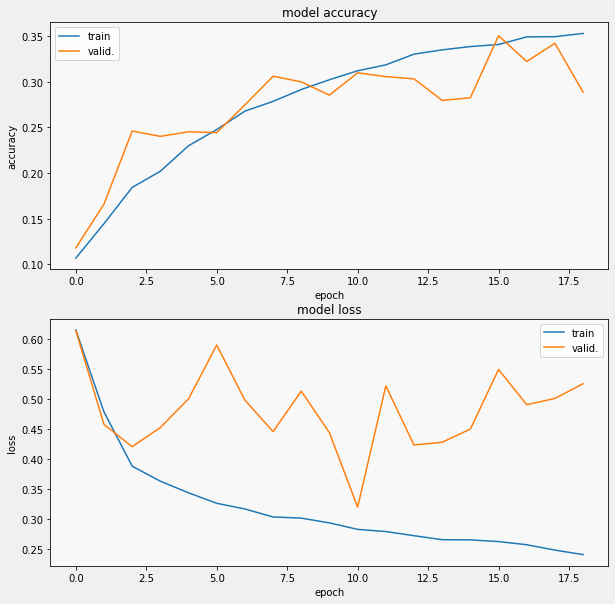

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_56_drop.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_28_drop.predict(x_val))

print(ms_error)

0.5253038559541575


In [ ]:
print(ms_error*price_train_std+price_train_mean)

56.51610123044446


### Stacked LSTM

Siguiente paso que haremos será pasar de un modelo Vanilla (simple, con sólo una capa oculta) a un modelo de LSTM Stacked, es decir, capas apiladas. 
Usaremos una LSTM de 56, con dropout del 40% y otra de 16 neuronas. 


In [ ]:
lstm_stacked = tf.keras.models.Sequential()
lstm_stacked.add(tf.keras.layers.LSTM(56, input_shape=x_train.shape[-2:], return_sequences=True))
lstm_stacked.add(tf.keras.layers.Dropout(0.4))
lstm_stacked.add(tf.keras.layers.LSTM(16))
lstm_stacked.add(tf.keras.layers.Dense(future_target))


lstm_stacked.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_stacked.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 47s 436ms/step - loss: 0.7309 - accuracy: 0.1183 - val_loss: 0.8137 - val_accuracy: 0.0888
Epoch 2/20
100/100 [==============================] - 43s 426ms/step - loss: 0.5710 - accuracy: 0.1338 - val_loss: 0.4997 - val_accuracy: 0.1100
Epoch 3/20
100/100 [==============================] - 43s 426ms/step - loss: 0.4162 - accuracy: 0.1638 - val_loss: 0.5146 - val_accuracy: 0.1427
Epoch 4/20
100/100 [==============================] - 43s 426ms/step - loss: 0.3503 - accuracy: 0.2119 - val_loss: 0.3801 - val_accuracy: 0.2332
Epoch 5/20
100/100 [==============================] - 43s 428ms/step - loss: 0.3177 - accuracy: 0.2651 - val_loss: 0.6121 - val_accuracy: 0.2253
Epoch 6/20
100/100 [==============================] - 43s 428ms/step - loss: 0.2992 - accuracy: 0.3044 - val_loss: 0.3503 - val_accuracy: 0.2743
Epoch 7/20
100/100 [==============================] - 43s 426ms/step - loss: 0.2821 - accuracy: 0.3186 - val_loss: 0.4770 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


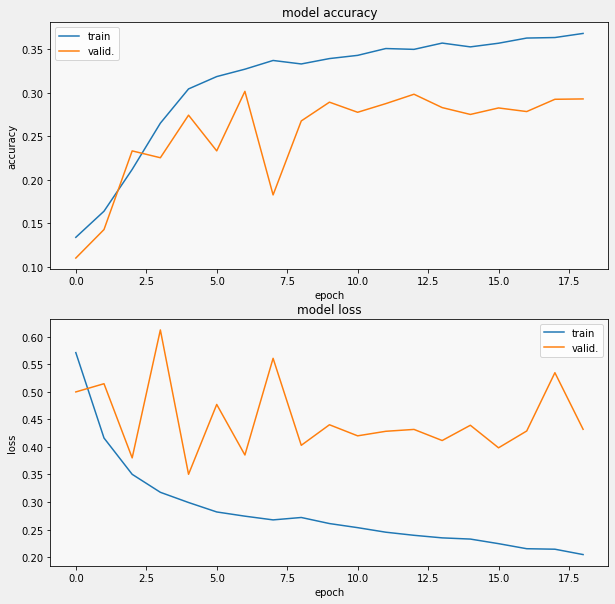

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

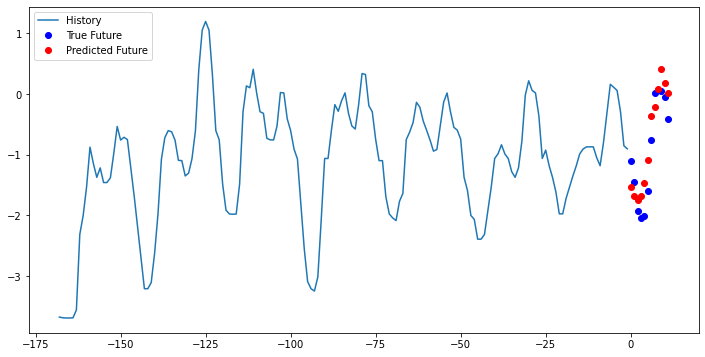

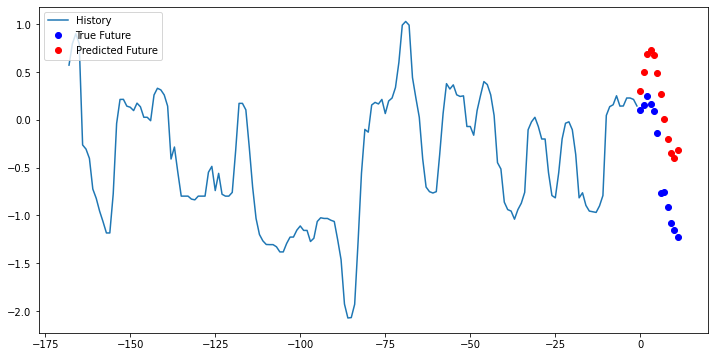

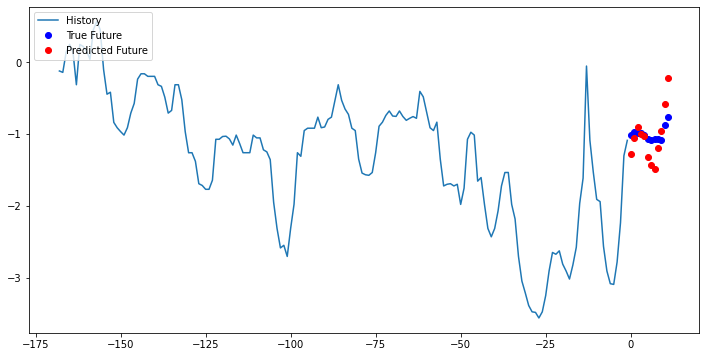

In [ ]:
for x, y in validation.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), lstm_stacked.predict(x)[0])

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_stacked.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_stacked.predict(x_val))

print(ms_error)

0.4319698149080722


In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

55.31644233916154


La accuracy sobre validación es del casi 28,4% y la performance del modelo deja bastante que desear debido a la loss de validación. 

### Stacked con bidireccional

Añadimos una capa Bidireccional, que básicamente nos permite conservar información del futuro (al igual que del pasado)

In [ ]:
lstm_stacked_2 = tf.keras.models.Sequential()
lstm_stacked_2.add(tf.keras.layers.LSTM(56, input_shape=x_train.shape[-2:], return_sequences=True))
lstm_stacked_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(28)))
lstm_stacked_2.add(tf.keras.layers.Dense(future_target))


lstm_stacked_2.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_stacked_2.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 65s 603ms/step - loss: 0.6556 - accuracy: 0.1188 - val_loss: 0.5211 - val_accuracy: 0.1124
Epoch 2/20
100/100 [==============================] - 59s 592ms/step - loss: 0.4129 - accuracy: 0.1746 - val_loss: 0.5151 - val_accuracy: 0.1817
Epoch 3/20
100/100 [==============================] - 59s 590ms/step - loss: 0.3037 - accuracy: 0.2663 - val_loss: 0.3173 - val_accuracy: 0.2664
Epoch 4/20
100/100 [==============================] - 59s 591ms/step - loss: 0.2411 - accuracy: 0.3199 - val_loss: 0.2798 - val_accuracy: 0.2988
Epoch 5/20
100/100 [==============================] - 60s 599ms/step - loss: 0.2086 - accuracy: 0.3508 - val_loss: 0.2841 - val_accuracy: 0.3494
Epoch 6/20
100/100 [==============================] - 60s 597ms/step - loss: 0.1950 - accuracy: 0.3715 - val_loss: 0.2851 - val_accuracy: 0.3282
Epoch 7/20
100/100 [==============================] - 59s 591ms/step - loss: 0.1743 - accuracy: 0.3855 - val_loss: 0.3810 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


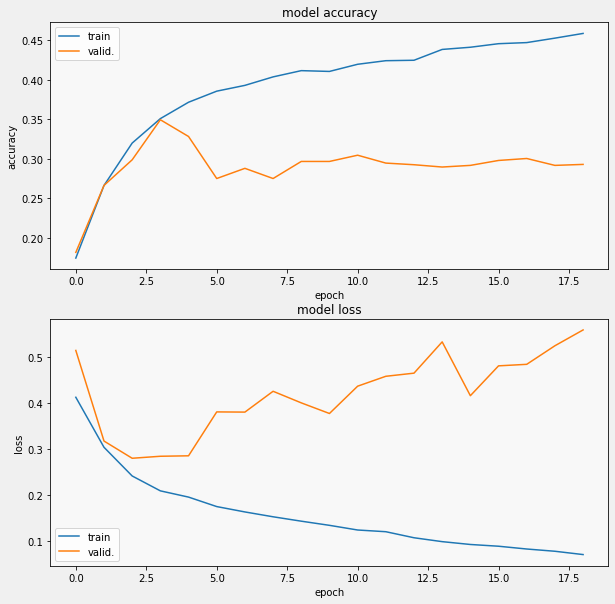

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
prediccions = lstm_stacked_2.predict(x_val)
ms_error = mse(y_true = y_val, y_pred = prediccions)
#mae = mae(y_true = y_val, y_pred = prediccions)

In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

56.96044005309685


Aunque la accuracy sobre el el conjunto de validación se mantienen en los 29%, la loss es totalmente creciente por lo que invalida este modelo. 


### Stacked con dropout

Usaremos con 3 capas ocultas de 56, 28 y 16 neuronas respectivamente, con un dropout del 15% y con activación tanh (tangente hiperbólica)

In [ ]:
lstm_stacked_3 = tf.keras.models.Sequential()
lstm_stacked_3.add(tf.keras.layers.LSTM(56,activation="tanh",return_sequences=True, input_shape=x_train.shape[-2:]))
lstm_stacked_3.add(tf.keras.layers.Dropout(0.15))
lstm_stacked_3.add(tf.keras.layers.LSTM(28,activation="tanh",return_sequences=True))
lstm_stacked_3.add(tf.keras.layers.Dropout(0.15))
lstm_stacked_3.add(tf.keras.layers.LSTM(16,activation="tanh",return_sequences=False))
lstm_stacked_3.add(tf.keras.layers.Dropout(0.15))
lstm_stacked_3.add(tf.keras.layers.Dense(future_target))


lstm_stacked_3.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_stacked_3.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 64s 590ms/step - loss: 0.7690 - accuracy: 0.0877 - val_loss: 0.9247 - val_accuracy: 0.0817
Epoch 2/20
100/100 [==============================] - 58s 581ms/step - loss: 0.5733 - accuracy: 0.1218 - val_loss: 0.4922 - val_accuracy: 0.1270
Epoch 3/20
100/100 [==============================] - 59s 589ms/step - loss: 0.4312 - accuracy: 0.1579 - val_loss: 0.4045 - val_accuracy: 0.2029
Epoch 4/20
100/100 [==============================] - 58s 582ms/step - loss: 0.3774 - accuracy: 0.2004 - val_loss: 0.8944 - val_accuracy: 0.1593
Epoch 5/20
100/100 [==============================] - 59s 587ms/step - loss: 0.3425 - accuracy: 0.2402 - val_loss: 0.5736 - val_accuracy: 0.2307
Epoch 6/20
100/100 [==============================] - 58s 584ms/step - loss: 0.3135 - accuracy: 0.2755 - val_loss: 0.6006 - val_accuracy: 0.2108
Epoch 7/20
100/100 [==============================] - 58s 581ms/step - loss: 0.3024 - accuracy: 0.2873 - val_loss: 0.5204 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


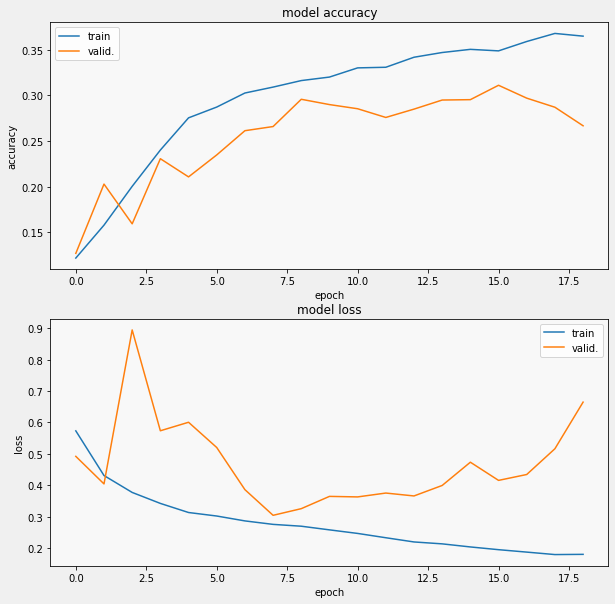

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

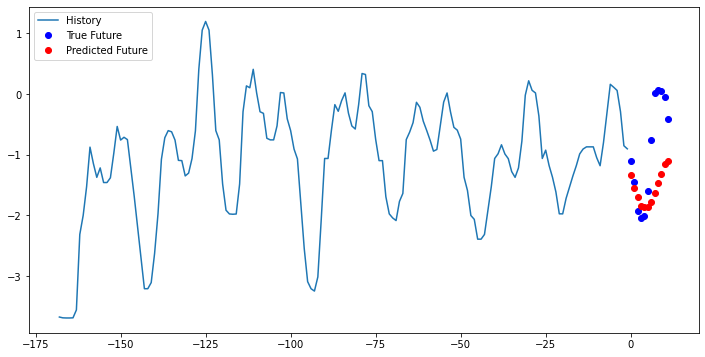

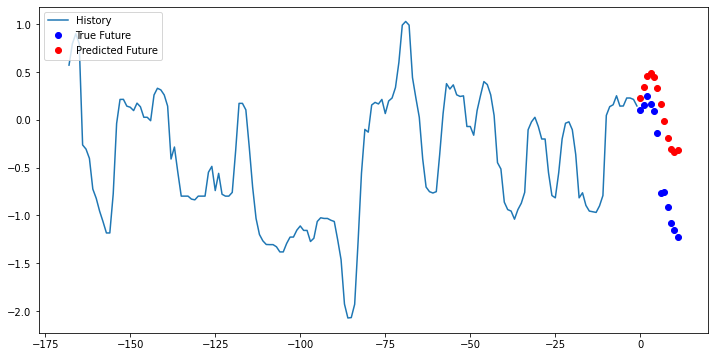

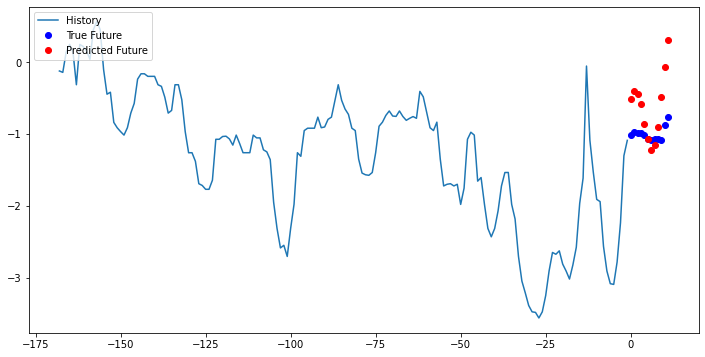

In [ ]:
for x, y in validation.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), lstm_stacked_3.predict(x)[0])

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_stacked_3.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_stacked.predict(x_val))

print(ms_error)

0.6647140600522431


In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

58.30799504547017


Nos encontramos con accuracy parecida a la de los mejores modelos, pero nos encontramos con una loss sobre validación creciente y una accuracy sobre validación que tiende al decreciente hacia el final del entreno. No es un buen modelo. 

### Modelo stacked sin dropout.

Usamos 3 capas ocultas con LSTM decrecientes y sin dropout. 

In [ ]:
lstm_stacked_6 = tf.keras.models.Sequential()
lstm_stacked_6.add(tf.keras.layers.LSTM(28,return_sequences=True, input_shape=x_train.shape[-2:]))
lstm_stacked_6.add(tf.keras.layers.LSTM(16,return_sequences=True))
lstm_stacked_6.add(tf.keras.layers.LSTM(8,return_sequences=False))
lstm_stacked_6.add(tf.keras.layers.Dense(future_target))


lstm_stacked_6.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_stacked_6.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 35s 305ms/step - loss: 0.8582 - accuracy: 0.0998 - val_loss: 2.0529 - val_accuracy: 0.1095
Epoch 2/20
100/100 [==============================] - 29s 295ms/step - loss: 0.6860 - accuracy: 0.0969 - val_loss: 1.0624 - val_accuracy: 0.1149
Epoch 3/20
100/100 [==============================] - 29s 293ms/step - loss: 0.5742 - accuracy: 0.1127 - val_loss: 0.7534 - val_accuracy: 0.1207
Epoch 4/20
100/100 [==============================] - 29s 295ms/step - loss: 0.4865 - accuracy: 0.1309 - val_loss: 0.5910 - val_accuracy: 0.1207
Epoch 5/20
100/100 [==============================] - 30s 297ms/step - loss: 0.4161 - accuracy: 0.1420 - val_loss: 0.4971 - val_accuracy: 0.1336
Epoch 6/20
100/100 [==============================] - 30s 295ms/step - loss: 0.3703 - accuracy: 0.1566 - val_loss: 0.4822 - val_accuracy: 0.1340
Epoch 7/20
100/100 [==============================] - 30s 296ms/step - loss: 0.3495 - accuracy: 0.1819 - val_loss: 0.4828 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


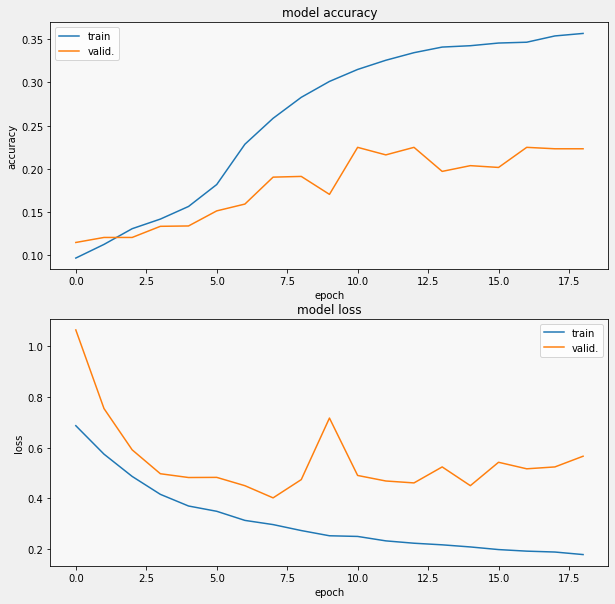

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_stacked_6.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_stacked.predict(x_val))

print(ms_error)

0.5659729740413358


In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

57.038837292947406


Tampoco nos serviría, no bate el modelo vanilla. 

### Stacked parecido al anterior pero usando tangente hiperbólica como función de activación. 

In [ ]:
lstm_stacked_7 = tf.keras.models.Sequential()
lstm_stacked_7.add(tf.keras.layers.LSTM(56,activation="tanh",return_sequences=True, input_shape=x_train.shape[-2:]))
lstm_stacked_7.add(tf.keras.layers.LSTM(28,activation="tanh",return_sequences=True))
lstm_stacked_7.add(tf.keras.layers.LSTM(16, activation='tanh'))
lstm_stacked_7.add(tf.keras.layers.Dense(future_target))


lstm_stacked_7.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')

EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_stacked_7.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 117s 551ms/step - loss: 0.7367 - accuracy: 0.0973 - val_loss: 0.9702 - val_accuracy: 0.0801
Epoch 2/20
100/100 [==============================] - 54s 537ms/step - loss: 0.5318 - accuracy: 0.1439 - val_loss: 0.5100 - val_accuracy: 0.1407
Epoch 3/20
100/100 [==============================] - 53s 533ms/step - loss: 0.3572 - accuracy: 0.2492 - val_loss: 0.3957 - val_accuracy: 0.1913
Epoch 4/20
100/100 [==============================] - 54s 536ms/step - loss: 0.3007 - accuracy: 0.3131 - val_loss: 0.6913 - val_accuracy: 0.2046
Epoch 5/20
100/100 [==============================] - 53s 533ms/step - loss: 0.2706 - accuracy: 0.3396 - val_loss: 0.5694 - val_accuracy: 0.2411
Epoch 6/20
100/100 [==============================] - 53s 534ms/step - loss: 0.2516 - accuracy: 0.3498 - val_loss: 0.4104 - val_accuracy: 0.2485
Epoch 7/20
100/100 [==============================] - 53s 533ms/step - loss: 0.2436 - accuracy: 0.3577 - val_loss: 0.4574 - val_a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


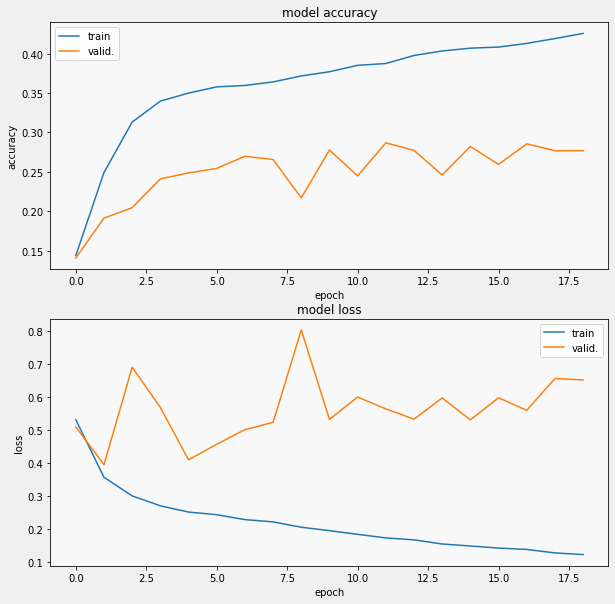

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

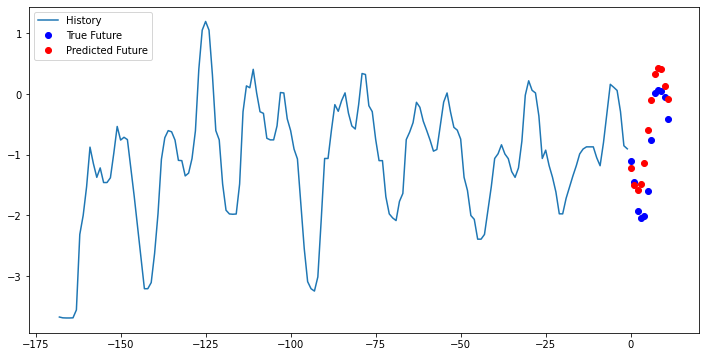

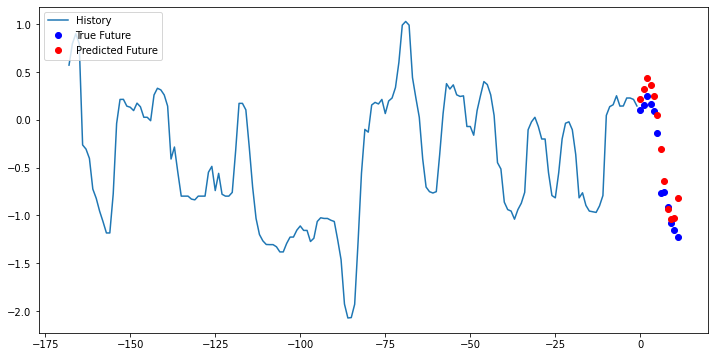

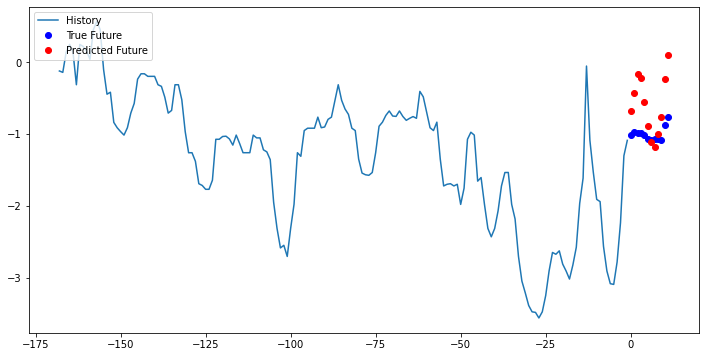

In [ ]:
for x, y in validation.take(3):
  multi_step_plot(x[0].numpy(), y[0].numpy(), lstm_stacked_7.predict(x)[0])

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_stacked_7.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_stacked_7.predict(x_val))

print(ms_error)

0.652864572783872


In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

58.15568895650927


Tampoco es el mejor modelo, la accuracy sobre el conjunto de validación ha bajado hasta el 27% y el MSE sube hasta 58. 

## Conclusiones

El mejor modelo hasta ahora es el vanilla de 28 neuronas con dropout, el MSE desnormalizado es de 53,99. 
Entonces he decidido hacer un grid-search para buscar, bajo el modelo vanilla con dropout, cuántas neuronas, % de dropout y bajo qué optimizador podríamos batir el modelo. 



In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(neurons=1, dropout=0.0, optimizer='adam'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(neurons, input_shape=x_train.shape[-2:]))
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(future_target))
                                  
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
  return model


model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=100)
# define the grid search parameters
neurons = [16, 28, 56, 72, 88]
dropout = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adamax']

param_grid = dict(neurons=neurons, dropout=dropout, optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

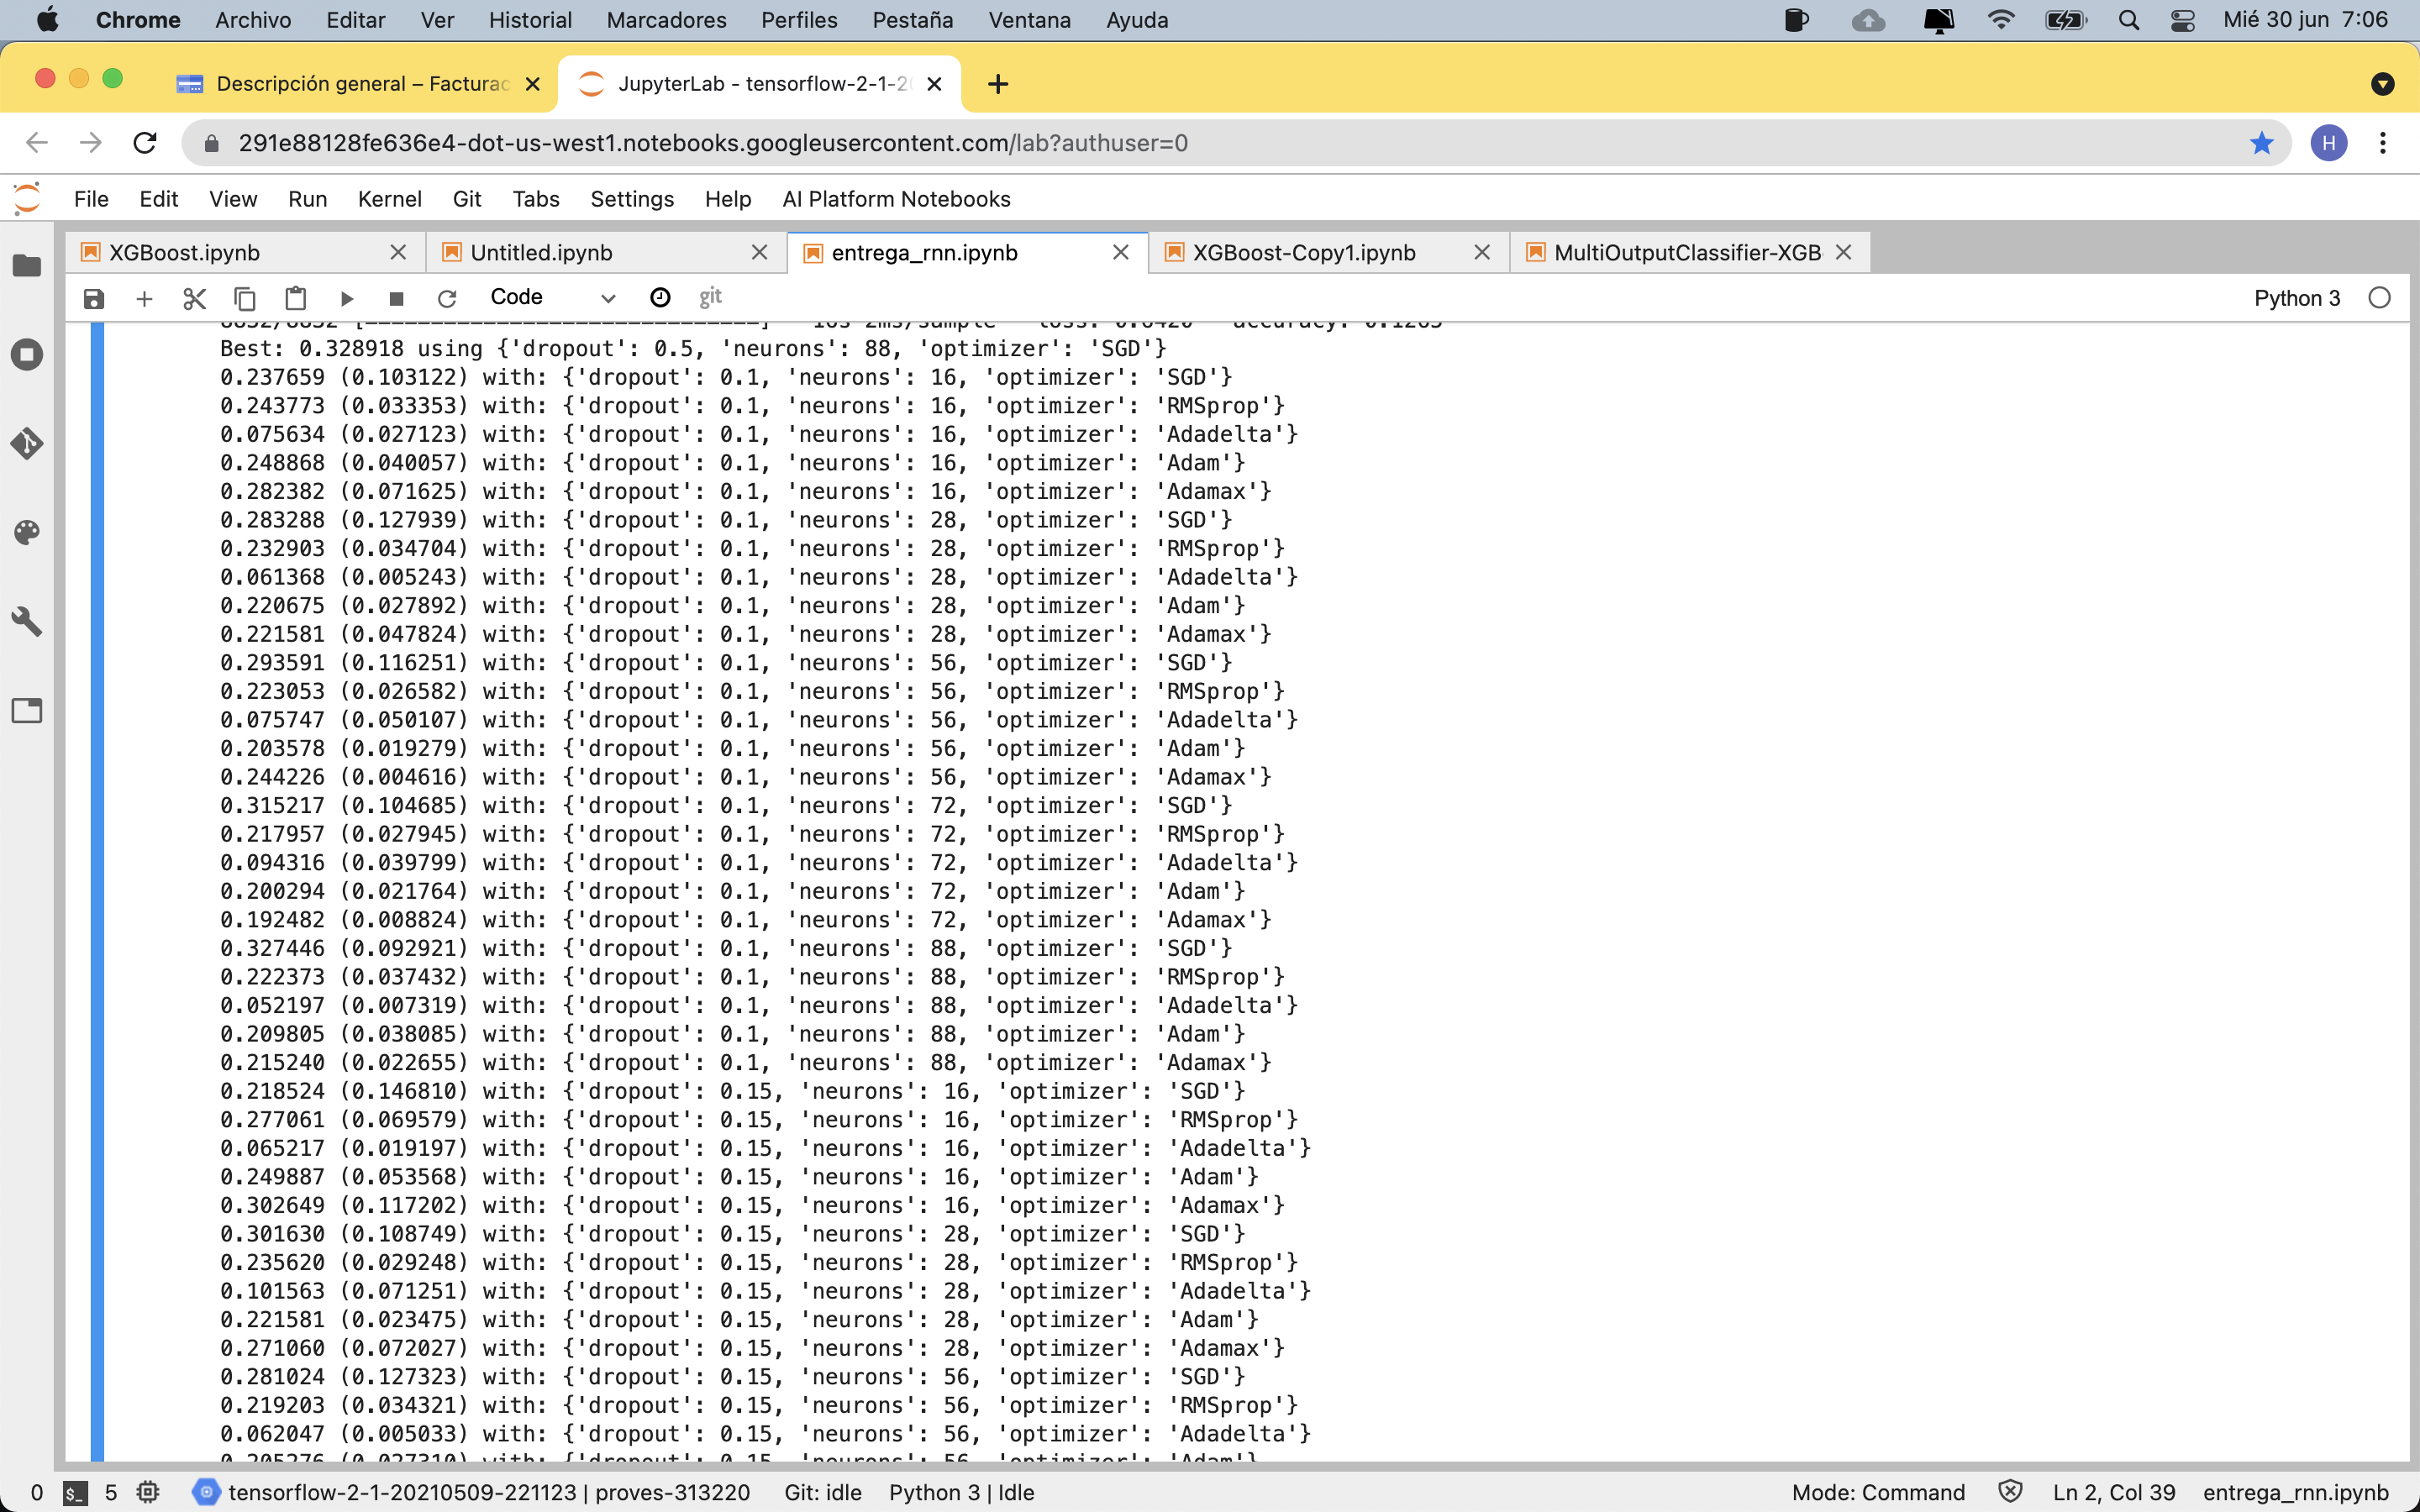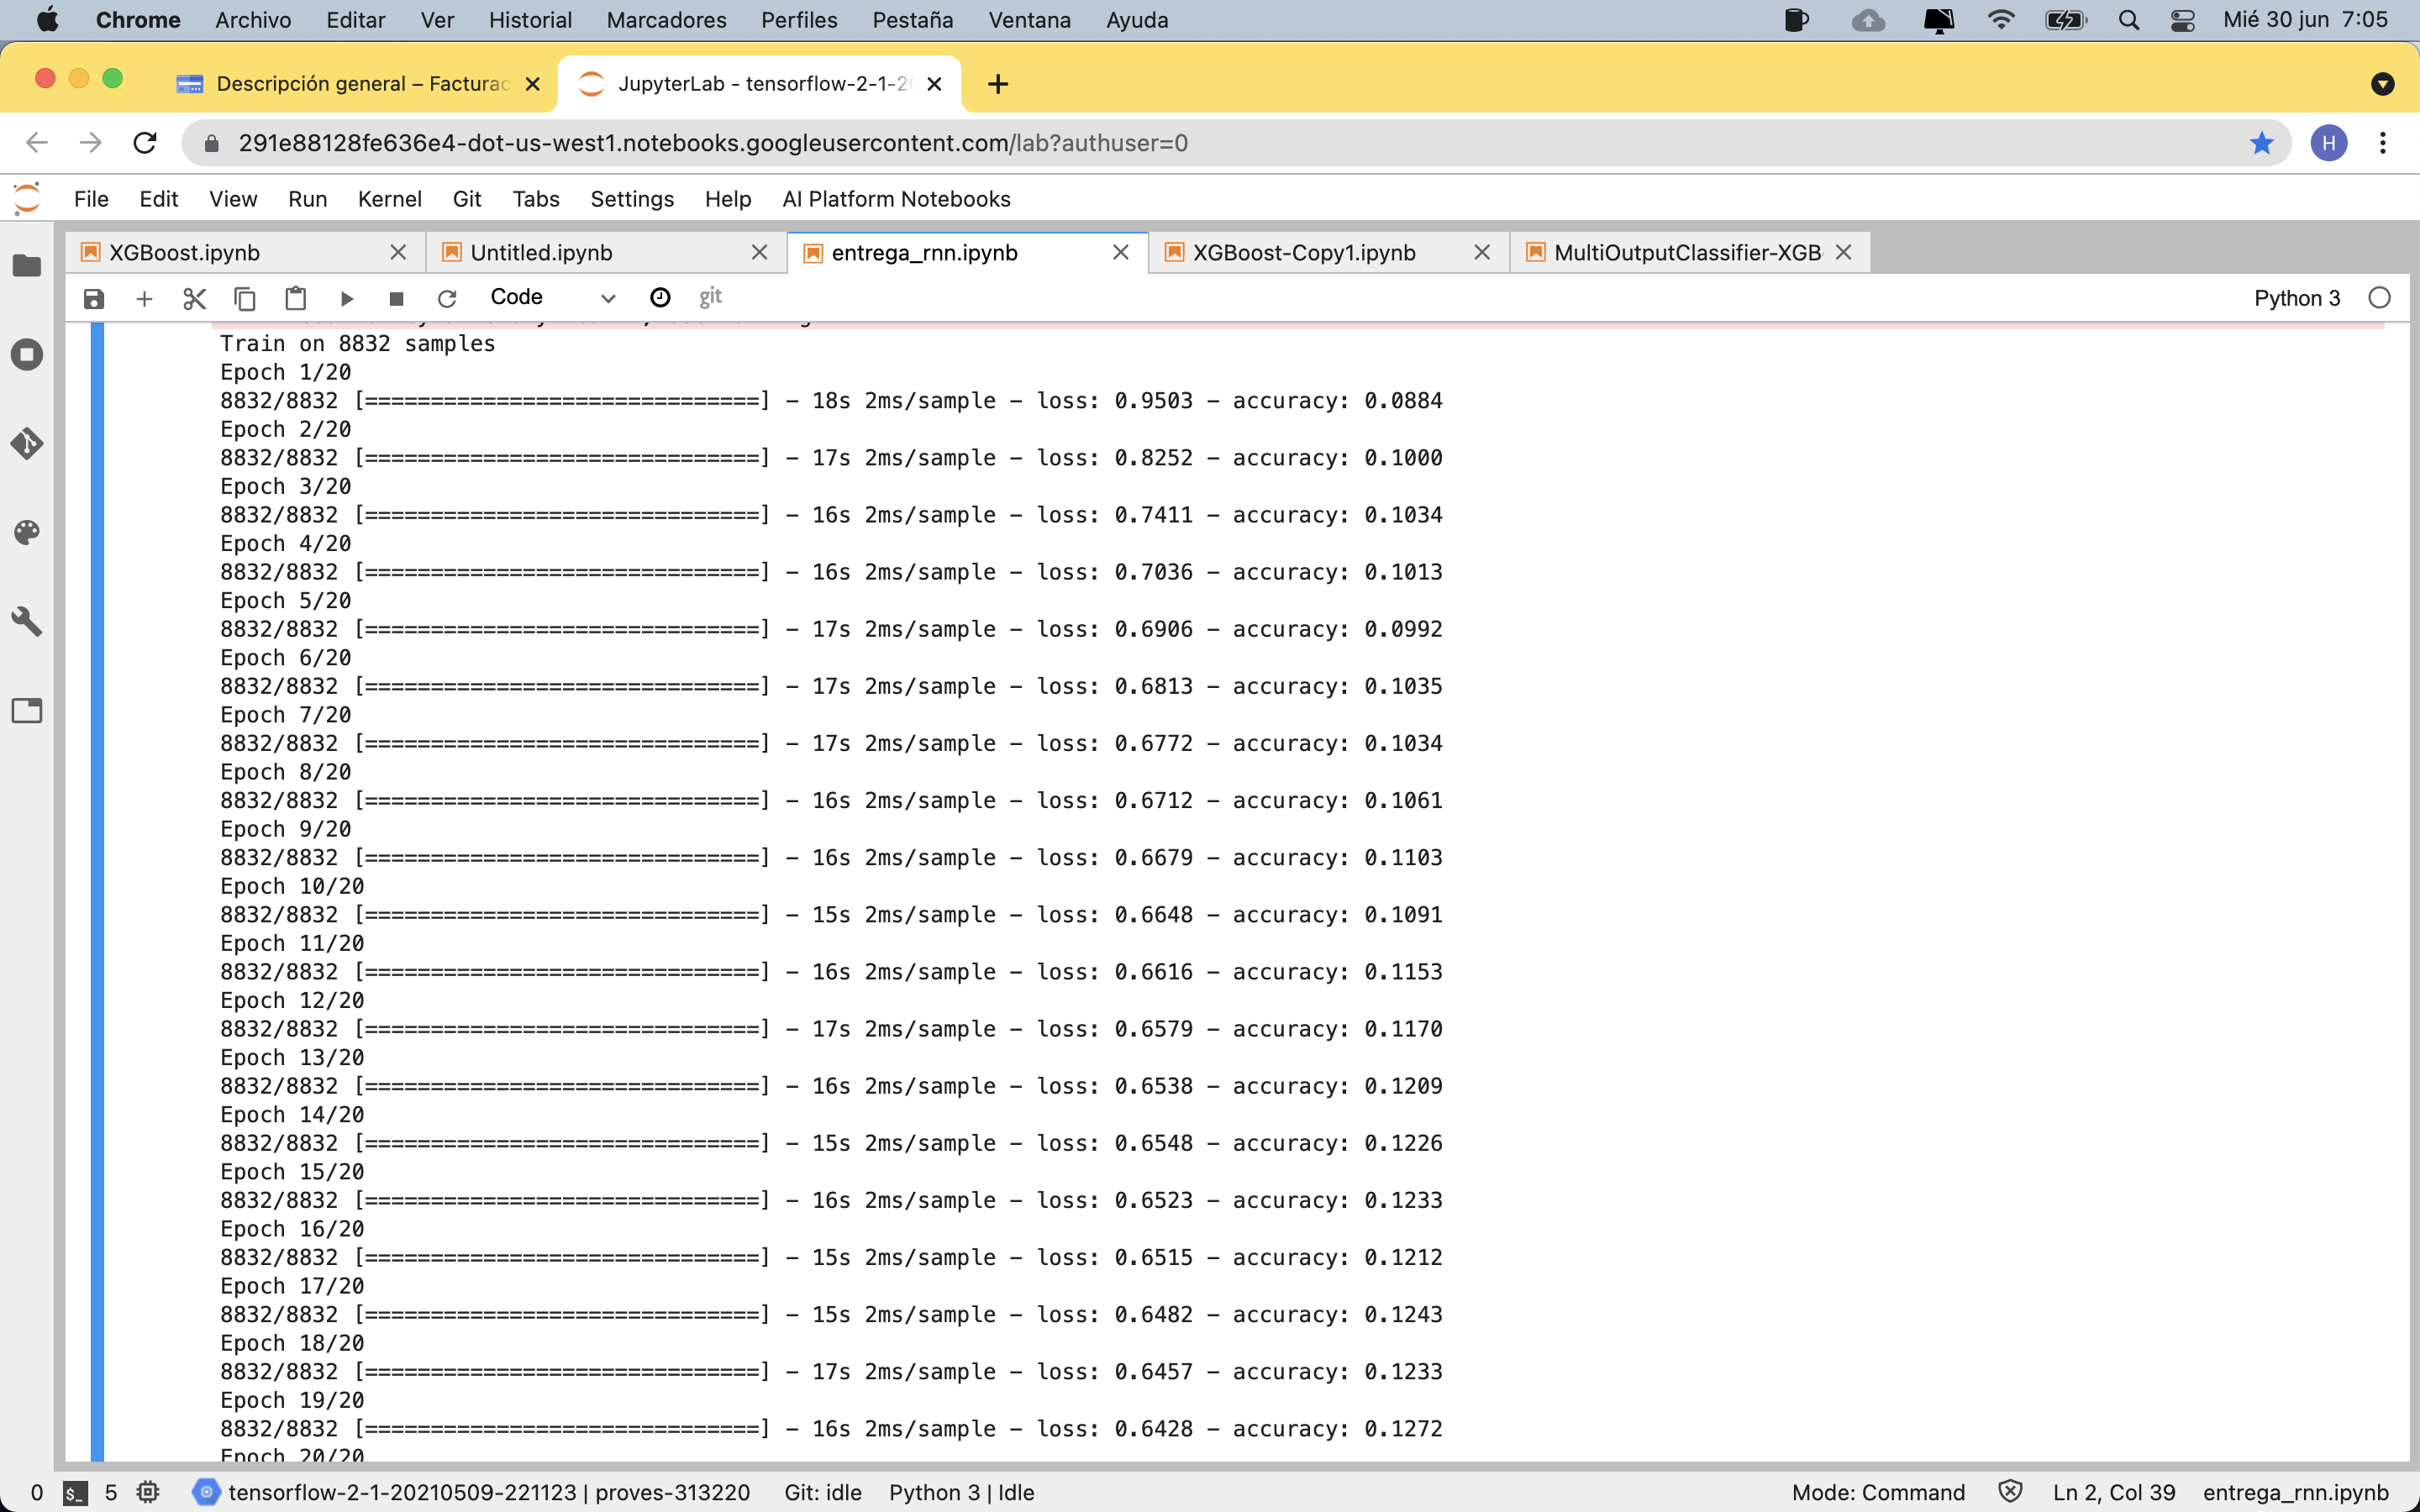

La primera vuelta vemos que el mejor modelo (lo he tenido que hacer con cloud porque tardó alrededor de 6 horas) es vanilla con 88 neuronas y un dropout del 0.5% con un optimizador SGD (aunque no le puse el learning rate)

In [ ]:
lstm_88_drop = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(88, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(future_target)
])

lstm_88_drop.compile(optimizer='SGD', loss='mean_squared_error', metrics='accuracy')


EVALUATION_INTERVAL = 100
EPOCHS = 20

start_time = time.time()
history = lstm_88_drop.fit(train, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=validation, #validation_steps=50, 
                      #callbacks=[tensorboard_callback]
                      )

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/20
100/100 [==============================] - 44s 423ms/step - loss: 0.9207 - accuracy: 0.0881 - val_loss: 2.4676 - val_accuracy: 0.0730
Epoch 2/20
100/100 [==============================] - 42s 415ms/step - loss: 0.7747 - accuracy: 0.0965 - val_loss: 1.7518 - val_accuracy: 0.0710
Epoch 3/20
100/100 [==============================] - 41s 414ms/step - loss: 0.7090 - accuracy: 0.0984 - val_loss: 1.3877 - val_accuracy: 0.0747
Epoch 4/20
100/100 [==============================] - 43s 435ms/step - loss: 0.6867 - accuracy: 0.1030 - val_loss: 1.2253 - val_accuracy: 0.0747
Epoch 5/20
100/100 [==============================] - 42s 417ms/step - loss: 0.6799 - accuracy: 0.1083 - val_loss: 1.1301 - val_accuracy: 0.0739
Epoch 6/20
100/100 [==============================] - 42s 419ms/step - loss: 0.6723 - accuracy: 0.1107 - val_loss: 1.0700 - val_accuracy: 0.0784
Epoch 7/20
100/100 [==============================] - 42s 415ms/step - loss: 0.6672 - accuracy: 0.1133 - val_loss: 1.0255 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


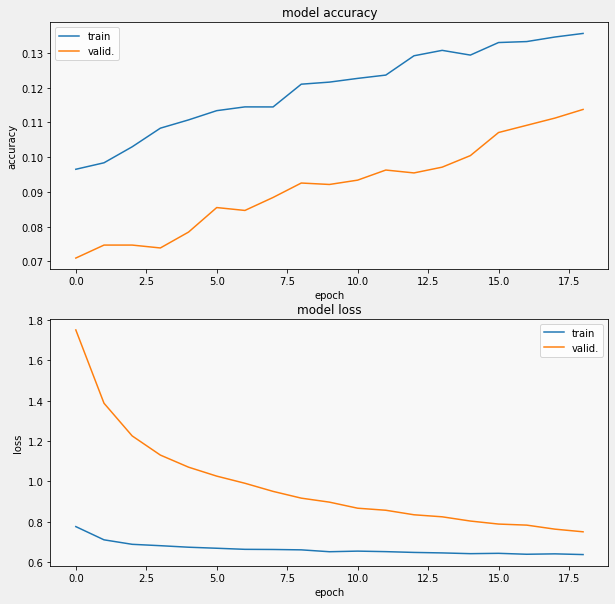

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [ ]:
ms_error = mse(y_true=y_val, y_pred=lstm_88_drop.predict(x_val))
#mae = mae(y_true=y_val, y_pred=lstm_stacked.predict(x_val))

print(ms_error)

0.748896166431719


In [ ]:
print(ms_error*price_train_std+price_train_mean)
#print(mae*price_train_std+price_train_mean)

59.390020545203946


El modelo se comporta muy bien, con una loss decreciente y sin picos; y una accuracy creciente. Aún así, tanto la accuracy de validación como entreno son bajas y el MSE está 3 puntos por encima del modelo baseline. Ergo no nos sirve.

### Conclusiones y modelo final

Escogemos el modelo Vanilla (sólo una capa oculta) con 28 neuronas y un dropout del 40% y con una semana de datos anteriores como entreno. El MeanSquaredError es de 53,99 y la accuracy del 26,8%.  
  
Bate al modelo baseline - Vanilla con capa de 8 neuronas y con 24h anteriores de entreno - con el que obteníamos una accuracy del 15,2% y un MSE de 56,47.  
  
Aunque es un modelo bastante pobre, hemos conseguido mejorar el baseline.   
  
  
Lo que deberíamos añadir a este modelo serían datos de consumo (tanto de hogares como empresas), y precios de los componentes de ese precio de la energía. Es decir, el precio de la energía aquí presente entiendo que se deberá componer de la energía producida por varios factores (eólica, nuclear, etc), con lo que cada componente tiene unos costes diferentes y se activan según demanda (a medida que aumenta la demanda, se añaden factores más costosos para la generación de esa energía por lo que puede conducir a picos). 

## Bibliografía

*   https://keras.io/api/losses/
*   https://androidkt.com/how-to-set-steps-per-epoch-validation-steps-and-validation-split-in-kerass-fit-method/
* https://neptune.ai/blog/tensorboard-tutorial
* https://towardsdatascience.com/recurrent-neural-networks-for-electricity-price-prediction-a26f8411ea44
* https://stats.stackexchange.com/questions/101560/tanh-activation-function-vs-sigmoid-activation-function
* https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
* https://www.kaggle.com/ahammedjaleel/sales-prediction-lstm

